The input of the NN is 1D. 

In [1]:
import numpy as np
import torch
import torch.nn as nn
import math
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

INPUT_SIZE = 1
OUTPUT_SIZE = 1

LOWER_BOUND = -10
UPPER_BOUND = 10
N_POINTS = 200

def quad_fn(a, b, c, x):
	return a*x**2 + b*x + c

def x_square(x: torch.tensor) -> torch.Tensor:
	return x**2

# DEFINE GIVEN FUNCTION V(x): ax^2 + bx + c
given_fn = x_square

In [2]:
# CUSTOM LOSS FUNCTION:
def epsilon_Loss(v_x, model_u, lower_bound, upper_bound, n_points):
    """
    GOAL: Epsilon function evaluated at u using discretized estimation
    minimizing Epsilon(u) = 
    
    ARGS: 
    n_points (int): number of discretized points on the interval [-L, L]
    e.g.: -(L)|---|---|---|---|(L) interval has n_points = 5

    v_x (torch.Tensor): function instance
    model_u (torch.Tensor): model output
    """
    sum = 0
    discrete_points = np.linspace(lower_bound, upper_bound, n_points)
    for i in discrete_points:
        x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
        u_xi = model_u(x_i)
        u_xi.backward()
        u_prime = x_i.grad
        v_xi = v_x(x_i)
        t = torch.abs(u_prime)**2 + v_xi*(u_xi**2)
        sum += t
        # print("x_i = " + str(x_i))
        # print("u_xi = " + str(u_xi))
        # print("u_prime = " + str(u_prime))
        # print("v_xi = " + str(v_xi))
        # print(t)
        # print('-----')

    return 0.5*sum

# NORMALIZE MODEL u(x) OUTPUT:
def normalize_u(model_u, lower_bound, upper_bound, n_points):
    discrete_points = np.linspace(lower_bound, upper_bound, n_points)
    h = discrete_points[1] - discrete_points[0]
    s = 0
    for i in discrete_points:
        x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
        t = model_u(x_i)**2
        s += t
    denom = math.sqrt(h) * torch.sqrt(s)

    return 1/denom

In [ ]:
v_x = given_fn
l_b = -10
u_b = 10
n_points = 200
model_u = Nonlinear_2(20)

# sum = 0
# d_points = np.linspace(l_b, u_b, n_points)
# for i in d_points:
#     x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
#     print("x_i = " + str(x_i))
#     u_xi = model_u(x_i)
#     print("u_xi = " + str(u_xi))
#     u_xi.backward()
#     u_prime = x_i.grad
#     print("u_prime = " + str(u_prime))
#     v_xi = v_x(x_i)
#     print("v_xi = " + str(v_xi))
#     foo = torch.abs(u_prime)**2 + v_xi*(u_xi**2)
#     print(foo)
#     print('-----')
#     sum += foo
# print(sum)


res = epsilon_Loss(given_fn, model_u, l_b, u_b, n_points)
model_u
# print(res)
# print(res.backward(gradient=))

Nonlinear_2(
  (hidden): Linear(in_features=1, out_features=20, bias=True)
  (output): Linear(in_features=20, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (tanh): Tanh()
)

In [3]:
# CREATING DATASET:
x_values = [i for i in np.linspace(LOWER_BOUND, UPPER_BOUND, N_POINTS)]
y_values = [given_fn(i) for i in x_values]

x_train = np.array(x_values, dtype=np.float32).reshape(-1, 1)
y_train = np.array(y_values, dtype=np.float32).reshape(-1, 1)

print(x_train.shape, y_train.shape)

(200, 1) (200, 1)


In [4]:
# PLOT DATA
def plot_figure(x_train, y_train, x_test=None, predicted=None):
    plt.clf()
    plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(x_train, y_train, 'go', label='True data', alpha=0.5)
    if predicted != None:
        plt.plot(x_test, predicted, '--', label='Predictions', alpha=0.5)
    plt.legend(loc='best')
    plt.show()

<Figure size 432x288 with 0 Axes>

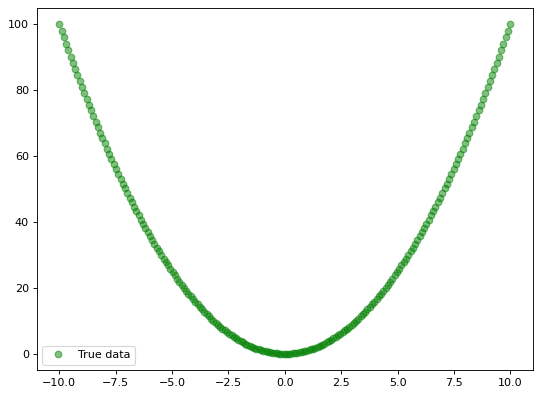

In [5]:
plot_figure(x_train, y_train)

In [6]:
# CREATING MODEL CLASS
class Nonlinear_2(nn.Module):
    def __init__(self, n):
        # One hidden layer with n nodes
        super().__init__()
        self.hidden = nn.Linear(1, n)
        self.output = nn.Linear(n, 1)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
    
    def forward(self, x, use_tanh_fn = False, activation_on_output = False):
        if use_tanh_fn == True:
            x = self.hidden(x)
            x = self.tanh(x)
            x = self.output(x)
            
        else:
            x = self.hidden(x)
            x = self.sigmoid(x)
            x = self.output(x)
            
        if activation_on_output == False:
            return x
        else:
            if use_tanh_fn == True:
                return self.tanh(x)
            else:       
                return self.sigmoid(x)
        # output is a linear combination of the hidden layers because 
        # we perform regression ???
        return x

In [7]:
# DEFINE HYPER-PARAMETERS
batch_size = 50
learningRate = 0.05
num_epochs = 2
# num_epochs = int(num_iters/(len(x_train)/batch_size))

#INIT PARAMETERS: 
v_x = given_fn
l_b = -10
u_b = 10
n_points = 5

#INIT MODEL
model = Nonlinear_2(20)
if torch.cuda.is_available():
    model.cuda()

# INIT OPTIMIZER CLASS
# What is an optimizer: 
# SGD:
# SGD_optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
# Adam:
adam_optimizer = torch.optim.Adam(model.parameters(), 
                                    lr=learningRate, 
                                    betas=(0.9, 0.999), 
                                    eps=1e-08, 
                                    weight_decay=0, 
                                    amsgrad=False)

# INIT LOSS FUNCTION: MSE
# criterion = epsilon_Loss


In [ ]:
# For plotting loss value over epochs:
x_epochs = [i for i in range(num_epochs)]
y_loss = []

# TRANING MODEL
def train_network():
    return 
    
for epoch in range(num_epochs):
    if epoch % 50 == 0:
        pass
        # normalize model.weight
    for (input, output) in (zip(x_train, y_train)):
        # if torch.cuda.is_available():
        #     input = Variable(torch.from_numpy(input).cuda())
        #     output = Variable(torch.from_numpy(output).cuda())
        # else:
        input = Variable(torch.from_numpy(input))
        output = Variable(torch.from_numpy(output))

        adam_optimizer.zero_grad()
        loss = epsilon_Loss(given_fn, model, LOWER_BOUND, UPPER_BOUND, N_POINTS)
        print(loss.data)
        print(type(loss))
        # TODO: calculate the derivative(loss) w.r.t the model's parameters
        # TODO: use adam optimizer to update the parameters
        # adam_optimizer.step()
    y_loss.append(loss)
    

    print('epoch {}, loss {}'.format(epoch, loss.item()))

In [33]:
i, o = (x_train[0], y_train[0])
i = Variable(torch.from_numpy(i))
o = Variable(torch.from_numpy(o))

loss = epsilon_Loss(given_fn, model, LOWER_BOUND, UPPER_BOUND, N_POINTS)
loss.backward()

RuntimeError: ignored

In [28]:
type(model.output.weight)

torch.nn.parameter.Parameter

In [ ]:
x = torch.rand(3, requires_grad=True)
print(x)
y = (x + 2)**2
v = torch.rand(3)

y.backward(v)
print(x.grad)

tensor([0.4108, 0.6806, 0.8073], requires_grad=True)
tensor([2.3363, 3.3781, 2.9445])


In [ ]:
(x+2)**2

tensor([5.8119, 7.1858, 7.8810], grad_fn=<PowBackward0>)

In [ ]:
v.grad

In [32]:
model.parameters

<bound method Module.parameters of Nonlinear_2(
  (hidden): Linear(in_features=1, out_features=20, bias=True)
  (output): Linear(in_features=20, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (tanh): Tanh()
)>

https://neptune.ai/blog/pytorch-loss-functions